In [466]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import time
import os
from pathlib import Path
from dotenv import load_dotenv

## **Data Gathering & Preparation**

### Get S&P 500 Data

In [251]:
# Import historical S&P 500 data (csv)
sp500_path = Path("resources/^GSPC.csv")  # Source: Yahoo Finance (https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1597708800&interval=1d&filter=history&frequency=1d)
sp500_df = pd.read_csv(sp500_path)
sp500_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
23262,2020-08-11,3370.340088,3381.010010,3326.439941,3333.689941,3333.689941,5087650000
23263,2020-08-12,3355.459961,3387.889893,3355.459961,3380.350098,3380.350098,3768560000
23264,2020-08-13,3372.949951,3387.239990,3363.350098,3373.429932,3373.429932,3648810000
23265,2020-08-14,3368.659912,3378.510010,3361.639893,3372.850098,3372.850098,3193400000
23266,2020-08-17,3380.860107,3387.590088,3379.219971,3381.989990,3381.989990,3671290000


In [252]:
# Clean historical S&P 500
# sp500_df = sp500_df.set_index('Date')
sp500_daily_historical = sp500_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
sp500_daily_historical = sp500_daily_historical.rename(columns={'Adj Close':'S&P 500'})
sp500_daily_historical = sp500_daily_historical.round(2)
sp500_daily_historical = sp500_daily_historical[:-3]
sp500_daily_historical['Date'] = pd.to_datetime(sp500_daily_historical['Date'])
sp500_daily_historical = sp500_daily_historical.set_index('Date')
# sp500_daily_historical.tail(3)

In [253]:
# Get most recent S&P 500 data 
import pandas_datareader.data as web
import datetime

# last_historical_day = sp500_daily_historical.iloc[-1]['Date']
# start = datetime.datetime.strptime(last_historical_day, '%Y-%m-%d').date()
# end = datetime.date.today()
sp500_current = web.DataReader(['sp500'], 'fred')
sp500_current = sp500_current.reset_index()
sp500_current = sp500_current.rename(columns={'DATE':'Date', 'sp500':'S&P 500'})
sp500_current = sp500_current.set_index('Date')
sp500_current.info()
# print(start, end)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2015-08-27 to 2020-08-24
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  1257 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


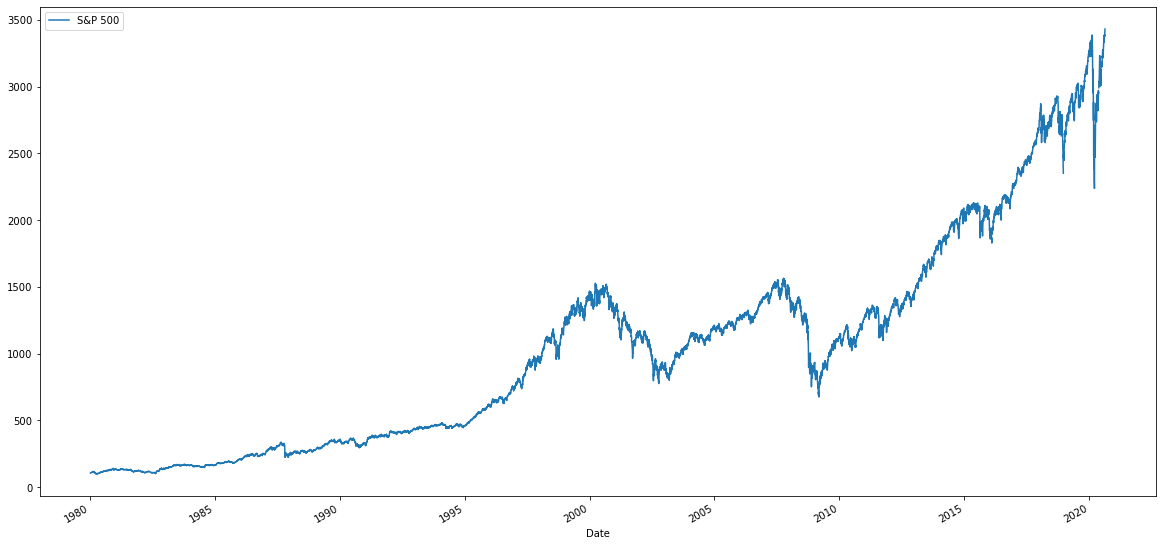

In [276]:
# Combine Historical S&P and Most recent S&P
sp500_daily = pd.concat([sp500_daily_historical, sp500_current], axis=0, join='outer')
# sp500_daily = pd.merge(sp500_daily_historical, sp500_current, left_on= ['Date', 'S&P 500'],
#                    right_on= ['DATE', 'sp500'], how='outer')
sp500_daily = sp500_daily.loc['1980':]
sp500_daily.plot(figsize=(20,10))

In [277]:
sp500_daily.head()

,S&P 500
Date,
1980-01-02,105.76
1980-01-03,105.22
1980-01-04,106.52
1980-01-07,106.81
1980-01-08,108.95


In [278]:
# Check if combined properly (Check if duplicate date)

# sp500_daily = sp500_daily.reset_index()
# sp500_daily[sp500_daily.duplicated(['Date'])]
# sp500_daily['Date'] = sp500_daily['Date'].drop_duplicates()
# sp500_daily = sp500_daily.set_index('Date')

In [279]:
# Drop rows with duplicated datetime index
sp500_daily['index'] = sp500_daily.index
sp500_daily= sp500_daily.drop_duplicates('index')
sp500_daily.set_index = sp500_daily['index']
sp500_daily= sp500_daily.drop('index', axis =1)

sp500_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10296 entries, 1980-01-02 to 2020-08-24
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  10250 non-null  float64
dtypes: float64(1)
memory usage: 160.9 KB


In [280]:
# Check if csv exist. If not, create new saved_stock csv (with sp500 in it)
stock_data_path = Path("resources/saved_stock.csv")
try:
    df = pd.read_csv(stock_data_path)
    print('csv exist')

except FileNotFoundError:
    sp500_daily.to_csv("resources/saved_stock.csv")
    print('No csv. Created new one')



csv exist


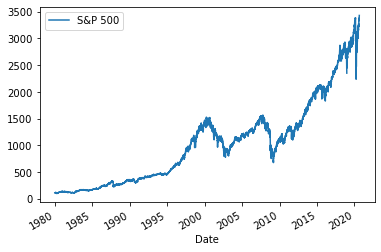

In [281]:
# sp500_daily.head()
sp500_daily.plot()

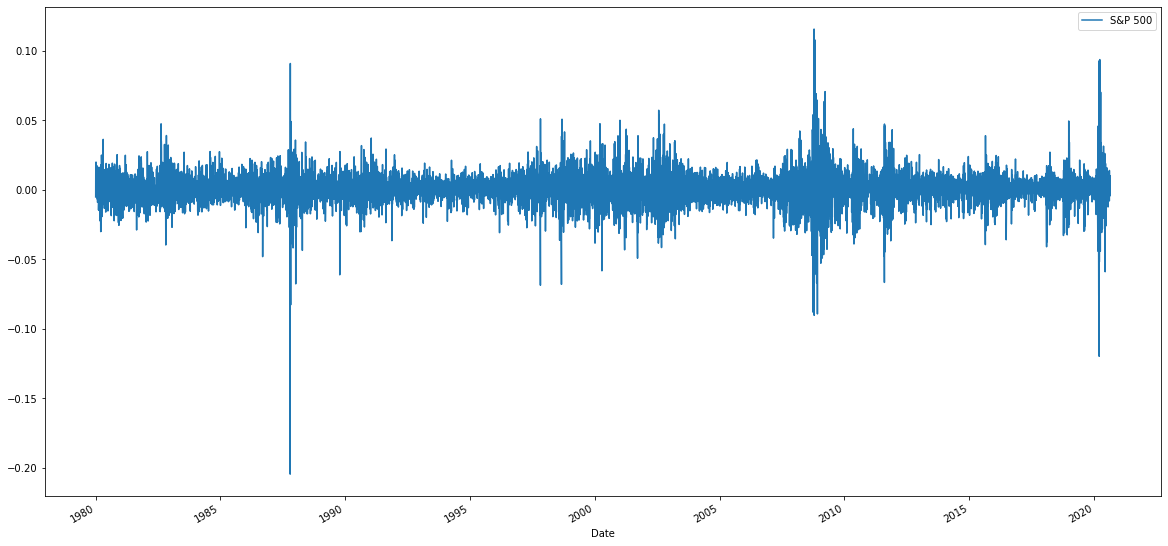

In [282]:
# Calculate Daily Returns - S&P 500
sp500_returns = sp500_daily.pct_change()
sp500_returns = sp500_returns.dropna()
sp500_returns.plot(figsize=(20,10))

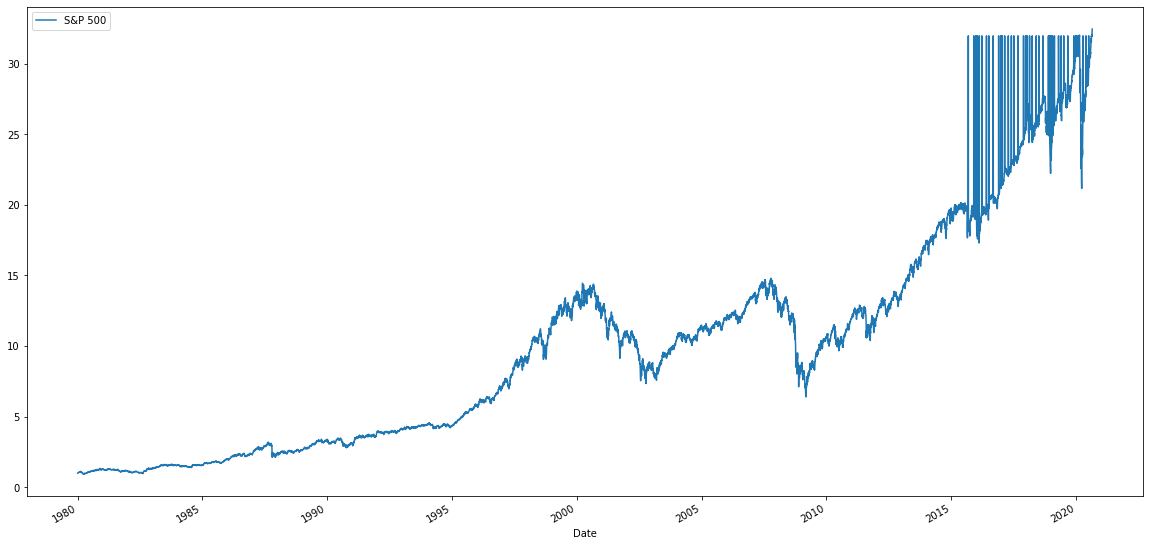

In [283]:
# Calculate Cumulative Returns - S&P 500
sp500_cum_returns = (1+sp500_returns).cumprod()
sp500_cum_returns.plot(figsize=(20,10))

In [284]:
# Calculate Standard Deviation - S&P 500
sp500_std = sp500_returns.std()
sp500_std

S&P 500    0.011286
dtype: float64

### Get Stock Data

In [285]:
load_dotenv()

True

In [286]:
# Get alpha-vantage api key
alphavantage_api_key = os.getenv("ALPHAVANTAGE_API_KEY")
type(alphavantage_api_key)

str

In [287]:
# import alpha-vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.timeseries import TimeSeries

ts = TimeSeries(key=alphavantage_api_key, output_format='pandas')

In [266]:
# def get_daily(quote):
#     """GET stock's daily adjusted data using alpha vantage api """
#     data, meta_data = ts.get_daily_adjusted(quote, outputsize='full')
#     data = data.sort_index(ascending=True)
#     return data

In [267]:
# def setup_adjusted_close(quote, stock_data):
#     """Clean stock data: drop col, rename col"""
#     stock_data = stock_data.drop(columns=['1. open', '2. high', '3. low', '4. close',
#            '6. volume', '7. dividend amount', '8. split coefficient'])
#     stock_data = stock_data.rename(columns = {'5. adjusted close':quote})
#     stock_data.index.names = ['Date']
#     #     stock_data.dropna(inplace=True)
#     return stock_data

In [397]:
# Load saved stock data (from previous runs)
stock_data_path = Path('resources/saved_stock.csv')
saved_stock_df = pd.read_csv(stock_data_path, index_col="Date", parse_dates=True, infer_datetime_format=True)
saved_stock_df.head(3)

,S&P 500,EA,TTWO,ATVI
Date,,,,
1980-01-02,105.76,NaN,NaN,NaN
1980-01-03,105.22,NaN,NaN,NaN
1980-01-04,106.52,NaN,NaN,NaN


In [399]:
# Get stock data from Alpha Vantage (if not already in csv)
def get_daily(df, get_stock_list, saved_stock_quote_list):
    """If stock not in saved df, call api (timeout for api request limit. AlphaVantage - 5 requests/min)"""

    for stock in get_stock_list:
        if stock not in saved_stock_quote_list:
            print('call api for ' + stock)
            data, meta_data = ts.get_daily_adjusted(stock, outputsize='full')
            df[stock] = data['5. adjusted close'].sort_index(ascending=True)
            time.sleep(12)
    return df

    
stock_list = ['EA', 'TTWO', 'ATVI',  # stocks to get from Alpha Vantage
             'XON', 'CVX', 'COP', 'HAL', 'KMI', 'PSX', 'EPD', 'ET', 'PAA',
             'LMT', 'RTN', 'LDOS', 'BA', 'NOC', 'GD', 'OSK', 'KBR',
             'FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'MSFT', 'IBM', 'INTC', 'PYPL',
             'GS', 'JPM', 'MS', 'BAC', 'C', 'CS', 'UBS',
             'UAL', 'LUV', 'DAL', 'AAL', 'ALK', 'JBLU', 'SAVE',
             'WM', 'RSG', 'WCN']  
saved_stock_quotes = list(saved_stock_df.columns)  # stocks already saved in csv
all_portfolio = get_daily(saved_stock_df, stock_list, saved_stock_quotes) # Get stock from AlphaVantage api
all_portfolio = all_portfolio.sort_index(ascending=True)
all_portfolio.tail()

call api for JPM
call api for MS
call api for BAC
call api for C
call api for CS
call api for UBS
call api for UAL
call api for LUV
call api for DAL
call api for AAL
call api for ALK
call api for JBLU
call api for SAVE
call api for WM
call api for RSG
call api for WCN


,S&P 500,EA,TTWO,ATVI,XON,CVX,COP,HAL,KMI,PSX,...,UAL,LUV,DAL,AAL,ALK,JBLU,SAVE,WM,RSG,WCN
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-18,3389.78,142.58,176.98,83.130,4.89,87.63,40.33,16.45,14.38,61.31,...,33.98,34.16,27.63,12.60,36.19,11.05,17.32,111.01,89.12,99.97
2020-08-19,3374.85,141.86,172.63,81.980,5.28,86.39,39.65,16.49,14.12,61.42,...,34.44,34.27,27.67,12.68,35.85,10.98,17.19,110.56,89.15,99.58
2020-08-20,3385.51,143.48,174.43,83.995,5.57,84.81,38.77,16.01,14.06,60.97,...,34.05,34.46,27.62,12.50,35.77,10.82,17.21,110.15,88.99,99.48
2020-08-21,3397.16,141.21,173.14,83.210,6.09,85.08,38.16,15.74,14.11,60.97,...,33.04,34.69,27.27,12.16,35.43,10.56,16.98,111.16,89.81,99.38
2020-08-24,3431.28,142.33,172.55,83.100,5.55,87.20,38.87,16.29,14.24,63.65,...,36.32,36.91,29.80,13.44,37.52,11.43,18.21,112.51,91.08,100.13


In [295]:
# def test_get_daily():
#     """ TEST get_daily. Should print 'call api for EA, stock exist', call api for ATVI"""
#     df = pd.DataFrame({'DATE':pd.date_range('2017-01-01', periods=5, freq='D'), 'FB':[1,2,3,4,5], 'AMZN':[7,6,9,8,0]})
#     df = df.set_index('DATE')
# #     test_stock_list = ['EA', 'FB', 'ATVI']
#     test_stock_list = ['EA', 'FB']
#     test_saved_stock_quotes = list(df.columns)
    
#     #Below - Code for get_daily()
#     for stock in test_stock_list:
#         if stock in test_saved_stock_quotes:
#             print('stock exist')
#         else:
#             data, meta_data = ts.get_daily_adjusted(stock, outputsize='full')
#             df[stock] = data['5. adjusted close'].sort_index(ascending=True)
#             print('call api for ' + stock)
#             time.sleep(12)
#     return df

# print(test_get_daily())

In [400]:
# Check data, ensure no duplicated datetime index 
all_portfolio.info()
idx = all_portfolio.index
print("\n" "number of duplicated datetime index: " + str(idx.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10296 entries, 1980-01-02 to 2020-08-24
Data columns (total 47 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  10250 non-null  float64
 1   EA       5237 non-null   float64
 2   TTWO     5237 non-null   float64
 3   ATVI     5237 non-null   float64
 4   XON      1774 non-null   float64
 5   CVX      5237 non-null   float64
 6   COP      5237 non-null   float64
 7   HAL      5237 non-null   float64
 8   KMI      2399 non-null   float64
 9   PSX      2106 non-null   float64
 10  EPD      5237 non-null   float64
 11  ET       466 non-null    float64
 12  PAA      5237 non-null   float64
 13  LMT      5237 non-null   float64
 14  RTN      5139 non-null   float64
 15  LDOS     3489 non-null   float64
 16  BA       5237 non-null   float64
 17  NOC      5237 non-null   float64
 18  GD       5237 non-null   float64
 19  OSK      5237 non-null   float64
 20  KBR      3465 non-null   float64


In [402]:
# Save stock into csv 
all_portfolio.to_csv("resources/saved_stock.csv")
all_portfolio.tail(3)

,S&P 500,EA,TTWO,ATVI,XON,CVX,COP,HAL,KMI,PSX,...,UAL,LUV,DAL,AAL,ALK,JBLU,SAVE,WM,RSG,WCN
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-20,3385.51,143.48,174.43,83.995,5.57,84.81,38.77,16.01,14.06,60.97,...,34.05,34.46,27.62,12.50,35.77,10.82,17.21,110.15,88.99,99.48
2020-08-21,3397.16,141.21,173.14,83.210,6.09,85.08,38.16,15.74,14.11,60.97,...,33.04,34.69,27.27,12.16,35.43,10.56,16.98,111.16,89.81,99.38
2020-08-24,3431.28,142.33,172.55,83.100,5.55,87.20,38.87,16.29,14.24,63.65,...,36.32,36.91,29.80,13.44,37.52,11.43,18.21,112.51,91.08,100.13


## **Portfolio Analysis**

### Data Preparation

In [488]:
# Import csv
df = pd.read_csv("resources/saved_stock.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
len(df.columns)

47

In [489]:
# Drop stock data with less than n years of record (due to lack of historical data in source, and bc it's been public for less than n years)
# Get stock data with more than n years of historical data

# Set time variables
n_years = 15
today = datetime.now()
start_year = (today - timedelta(days=n_years*365)).year

lt_n_yr_stocks = [col for col in df if df[col].count() < (252 * n_years)]  # 252 trading days in a year
all_portfolio = df.drop(columns=lt_n_yr_stocks)
all_portfolio = all_portfolio.loc[str(start_year):]

print(f'Stocks dropped (stocks with less than {n_years} years of historical data): \n {lt_n_yr_stocks}')
print()
all_portfolio.info()

Stocks dropped (stocks with less than 15 years of historical data): 
 ['XON', 'KMI', 'PSX', 'ET', 'LDOS', 'KBR', 'FB', 'GOOG', 'PYPL', 'UBS', 'UAL', 'DAL', 'AAL', 'SAVE']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3984 entries, 2005-01-03 to 2020-08-24
Data columns (total 33 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  3938 non-null   float64
 1   EA       3938 non-null   float64
 2   TTWO     3938 non-null   float64
 3   ATVI     3938 non-null   float64
 4   CVX      3938 non-null   float64
 5   COP      3938 non-null   float64
 6   HAL      3938 non-null   float64
 7   EPD      3938 non-null   float64
 8   PAA      3938 non-null   float64
 9   LMT      3938 non-null   float64
 10  RTN      3840 non-null   float64
 11  BA       3938 non-null   float64
 12  NOC      3938 non-null   float64
 13  GD       3938 non-null   float64
 14  OSK      3938 non-null   float64
 15  AAPL     3938 non-null   float64
 16  AMZN     3938 

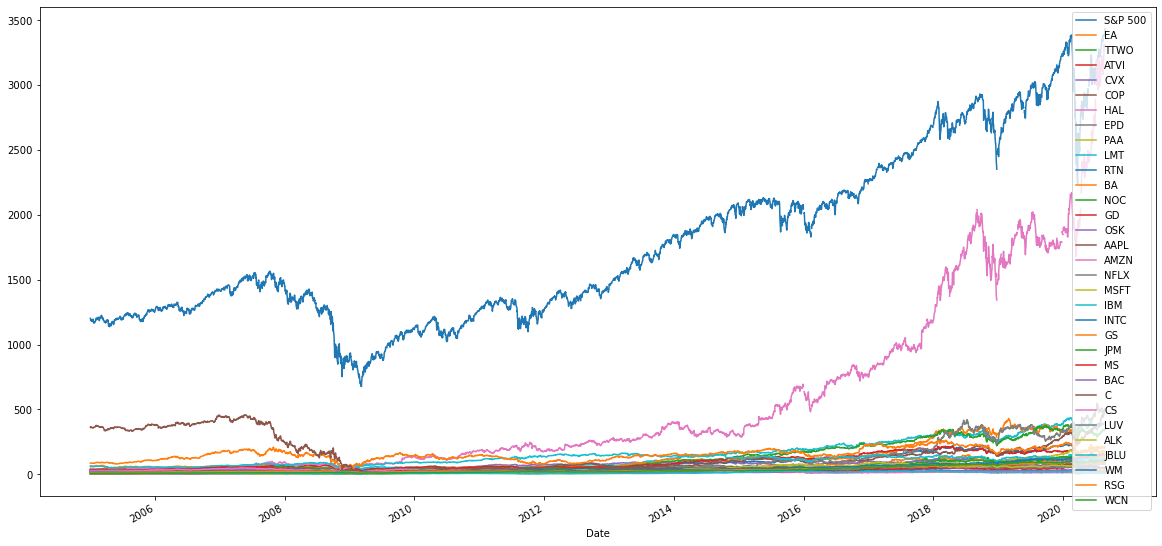

In [490]:
all_portfolio.plot(figsize=(20,10))

In [496]:
# Set Industry Portfolio
def set_portfolio(all_portfolio, industry_stocks_ls):
    """Get industry stock data from portfolio if it exist"""
    industry_portfolio = all_portfolio[[stock for stock in industry_stocks_ls if stock in all_portfolio]]
    return industry_portfolio

# Define stocks in each industry
gaming_industry = ['EA', 'TTWO', 'ATVI']
oil_industry = ['XON', 'CVX', 'COP', 'HAL', 'KMI', 'PSX', 'EPD', 'ET', 'PAA']
defense_industry = ['LMT', 'RTN', 'LDOS', 'BA', 'NOC', 'GD', 'OSK', 'KBR']
tech_industry = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'MCST', 'IBM', 'INTC', 'PYPL']
finance_industry = ['GS' 'JPM', 'MS', 'BAC', 'C', 'CS', 'UBS']
airlines_industry = ['UAL', 'LUV', 'DAL', 'AAL', 'ALK', 'JBLU', 'SAVE']
wasteservice_industry = ['WM', 'RSG', 'WCN']

# Set industry portfolio (DataFrame)
sp500_index = set_portfolio(all_portfolio, ['S&P 500'])
gaming_portfolio = set_portfolio(all_portfolio, gaming_industry)
oil_portfolio = set_portfolio(all_portfolio, oil_industry)
defense_portfolio = set_portfolio(all_portfolio, defense_industry)
tech_portfolio = set_portfolio(all_portfolio, tech_industry)
finance_portfolio = set_portfolio(all_portfolio, finance_industry)
airlines_portfolio = set_portfolio(all_portfolio, airlines_industry)
wasteservices_portfolio = set_portfolio(all_portfolio, wasteservice_industry)

# Print remaining stocks in each portfolio (After filtering by length of history)
all_industry_portfolio = [sp500_index, gaming_portfolio, oil_portfolio , defense_portfolio, tech_portfolio , finance_portfolio , airlines_portfolio , wasteservices_portfolio] 
all_industry_names = ['sp500_index', 'gaming_portfolio', 'oil_portfolio' , 'defense_portfolio', 'tech_portfolio' , 'finance_portfolio' , 'airlines_portfolio' , 'wasteservices_portfolio'] 

for i in range(len(all_industry_portfolio)):
    print(f'{all_industry_names[i]} {list(all_industry_portfolio[i].columns)}')


sp500_index ['S&P 500']
gaming_portfolio ['EA', 'TTWO', 'ATVI']
oil_portfolio ['CVX', 'COP', 'HAL', 'EPD', 'PAA']
defense_portfolio ['LMT', 'RTN', 'BA', 'NOC', 'GD', 'OSK']
tech_portfolio ['AAPL', 'AMZN', 'NFLX', 'IBM', 'INTC']
finance_portfolio ['MS', 'BAC', 'C', 'CS']
airlines_portfolio ['LUV', 'ALK', 'JBLU']
wasteservices_portfolio ['WM', 'RSG', 'WCN']


In [497]:
# Check data
pd.concat([sp500_index, gaming_portfolio, oil_portfolio , defense_portfolio, tech_portfolio , finance_portfolio , airlines_portfolio , wasteservices_portfolio], axis=1).tail()

,S&P 500,EA,TTWO,ATVI,CVX,COP,HAL,EPD,PAA,LMT,...,MS,BAC,C,CS,LUV,ALK,JBLU,WM,RSG,WCN
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-18,3389.78,142.58,176.98,83.130,87.63,40.33,16.45,18.43,7.40,390.26,...,50.92,25.53,50.34,11.11,34.16,36.19,11.05,111.01,89.12,99.97
2020-08-19,3374.85,141.86,172.63,81.980,86.39,39.65,16.49,18.26,7.36,390.05,...,51.37,25.50,50.29,11.15,34.27,35.85,10.98,110.56,89.15,99.58
2020-08-20,3385.51,143.48,174.43,83.995,84.81,38.77,16.01,18.16,7.45,387.88,...,50.80,25.10,49.58,11.04,34.46,35.77,10.82,110.15,88.99,99.48
2020-08-21,3397.16,141.21,173.14,83.210,85.08,38.16,15.74,18.12,7.28,389.57,...,51.10,24.98,49.30,10.96,34.69,35.43,10.56,111.16,89.81,99.38
2020-08-24,3431.28,142.33,172.55,83.100,87.20,38.87,16.29,18.08,7.17,395.04,...,52.37,25.69,51.06,11.15,36.91,37.52,11.43,112.51,91.08,100.13


### All Stocks Analysis

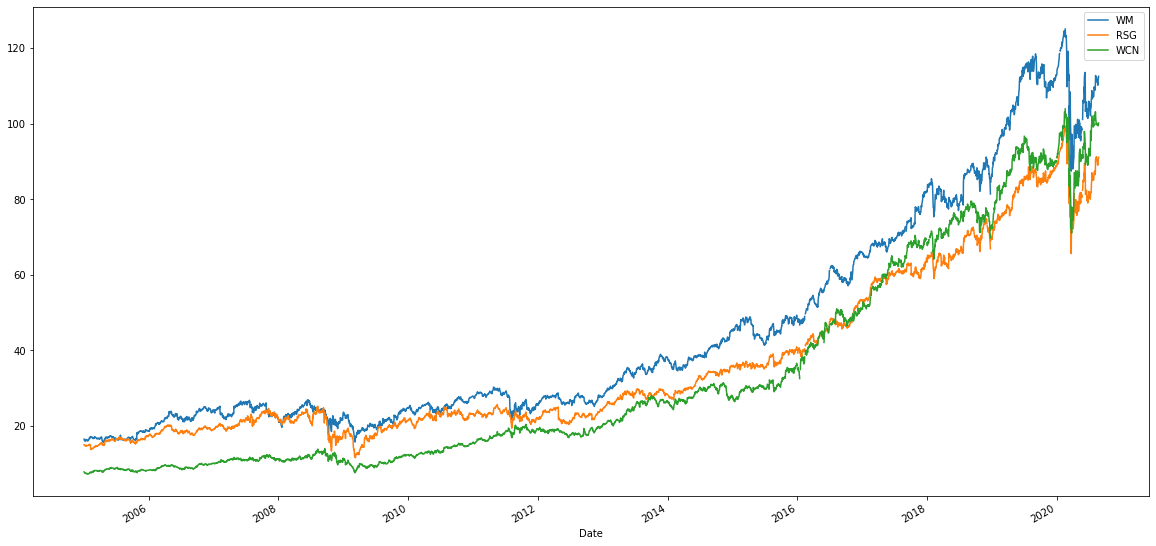

In [498]:
# Plot - Gaming Industry
wasteservices_portfolio.plot(figsize=(20,10))

In [499]:
# Calculate Daily Returns - 
wasteservices_returns = wasteservices_portfolio.pct_change()
wasteservices_returns = wasteservices_returns.dropna()
wasteservices_returns.head()

,WM,RSG,WCN
Date,,,
2005-01-04,-0.011171,-0.003315,-0.009490
2005-01-05,-0.008220,-0.007548,-0.013470
2005-01-06,-0.005179,-0.002436,0.001214
2005-01-07,-0.004858,-0.003657,-0.021825
2005-01-10,-0.002791,0.008261,0.006198


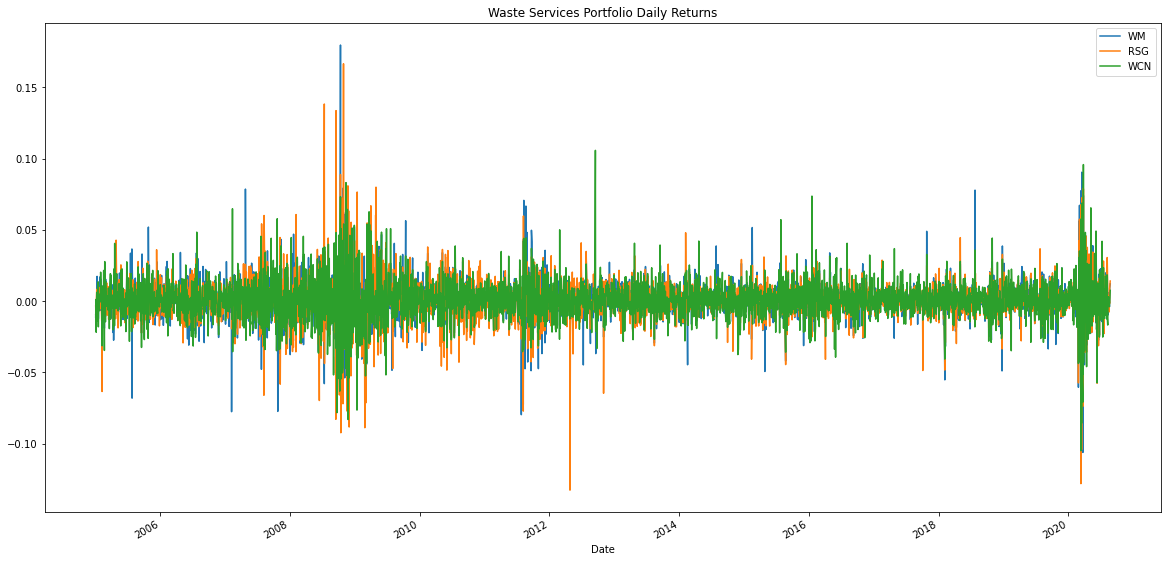

In [500]:
# Plot Daily Returns
wasteservices_returns.plot(figsize=(20, 10), title="Waste Services Portfolio Daily Returns")

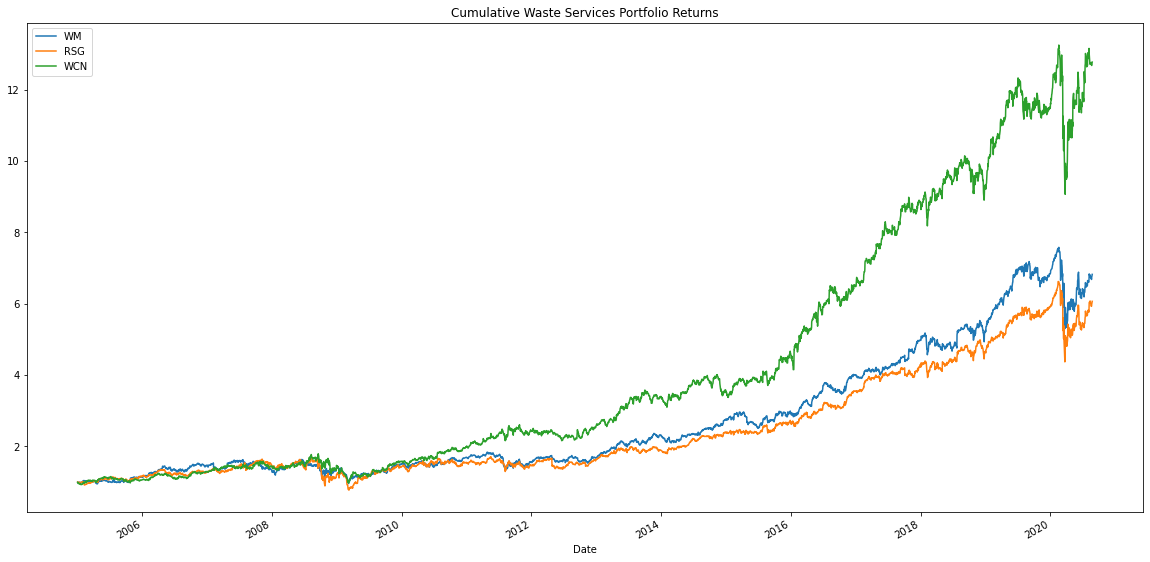

In [502]:
# Plot Cumulative Returns - Gaming Portfolio
wasteservices_cumulative_returns = (1 + wasteservices_returns).cumprod()
wasteservices_cumulative_returns.plot(figsize=(20,10), title="Cumulative Waste Services Portfolio Returns")

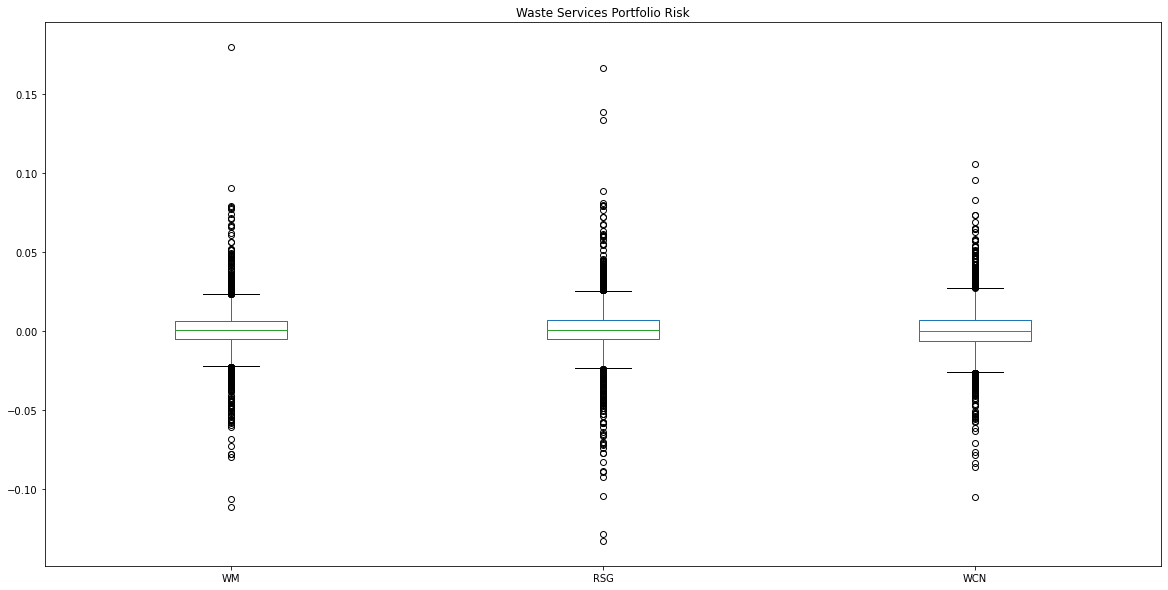

In [504]:
# Box Plot - Daily Returns - Gaming Portfolio
wasteservices_returns.plot.box(figsize=(20, 10), title="Waste Services Portfolio Risk")

In [505]:
# Daily Standard Deviations - Gaming Portfolio
wasteservices_returns.std()

WM     0.013621
RSG    0.014716
WCN    0.013894
dtype: float64

In [506]:
# Calculate the annualized standard deviation (252 trading days)
wasteservices_returns.std() * np.sqrt(252)

WM     0.216220
RSG    0.233605
WCN    0.220556
dtype: float64

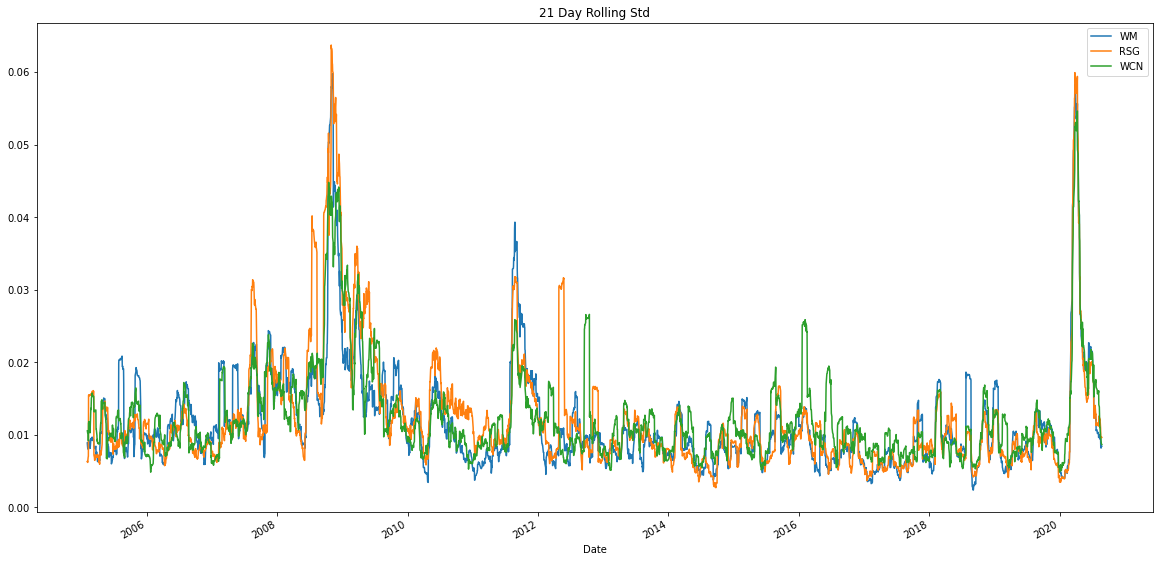

In [507]:
# Rolling Std - Gaming Industry
wasteservices_returns.rolling(window=21).std().plot(figsize=(20, 10), title="21 Day Rolling Std")

In [508]:
# Correlation table - Gaming Industry
corr_df = wasteservices_returns.corr()
corr_df.style.background_gradient()

,WM,RSG,WCN
WM,1.000000,0.677134,0.598247
RSG,0.677134,1.000000,0.574870
WCN,0.598247,0.574870,1.000000
